<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment and Imports

In [1]:
import os
os.environ["PYTHONHASHSEED"] = "0"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mcnemar
import scipy.stats as stats

# Reproducibility Utilities

In [3]:
def set_all_seeds(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
def reset_tf():
    tf.keras.backend.clear_session()

# Data Loading

In [5]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [6]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Anything beyond this section ending with "1" is representing the dataframe WITHOUT macro features. While "2" is representing WITH macro features.

In [7]:
TARGET_1 = 'btc_logret'

In [8]:
FEATURES_1 = [
    'btc_price', 'open', 'high', 'low', 'volume',
    'btc_ma50', 'btc_ma200'
]

In [9]:
TARGET_2 = 'btc_logret'

In [10]:
FEATURES_2 = [
    'btc_price','open','high','low','volume',
    'spx_price','xau_price', 'vix_price', 'dxy_price',
    'spx_logret','xau_logret', 'vix_logret', 'dxy_logret',
    'spx_logret_lag1','spx_logret_lag3','spx_logret_lag7',
    'xau_logret_lag1','xau_logret_lag3','xau_logret_lag7',
    'vix_logret_lag1','vix_logret_lag3','vix_logret_lag7',
    'dxy_logret_lag1','dxy_logret_lag3','dxy_logret_lag7',
    'btc_ma50','btc_ma200'
]

# Train - Val - Test Split

In [11]:
total_len = len(df)

In [12]:
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

In [13]:
train_df.shape

(2629, 29)

In [14]:
val_df.shape

(564, 29)

In [15]:
test_df.shape

(564, 29)

# Scaling

In [16]:
scaler_1 = MinMaxScaler()

In [17]:
scaler_1.fit(train_df[FEATURES_1])

MinMaxScaler()

In [18]:
train_scaled_1 = scaler_1.transform(train_df[FEATURES_1])
val_scaled_1 = scaler_1.transform(val_df[FEATURES_1])
test_scaled_1 = scaler_1.transform(test_df[FEATURES_1])

In [19]:
scaler_2 = MinMaxScaler()

In [20]:
scaler_2.fit(train_df[FEATURES_2])

MinMaxScaler()

In [21]:
train_scaled_2 = scaler_2.transform(train_df[FEATURES_2])
val_scaled_2 = scaler_2.transform(val_df[FEATURES_2])
test_scaled_2 = scaler_2.transform(test_df[FEATURES_2])

# GRU Sequence Data

In [22]:
def make_sequence_data(values, target, lookback):
  X, y = [], []

  for i in range(lookback, len(values)):
    X.append(values[i-lookback:i])
    y.append(target[i])

  return np.array(X), np.array(y)

In [23]:
LOOKBACK = 60

In [24]:
X_train_1, y_train_1 = make_sequence_data(train_scaled_1, train_df[TARGET_1].values, LOOKBACK)
X_val_1, y_val_1 = make_sequence_data(val_scaled_1, val_df[TARGET_1].values, LOOKBACK)
X_test_1, y_test_1 = make_sequence_data(test_scaled_1, test_df[TARGET_1].values, LOOKBACK)

X_train_2, y_train_2 = make_sequence_data(train_scaled_2, train_df[TARGET_2].values, LOOKBACK)
X_val_2, y_val_2 = make_sequence_data(val_scaled_2, val_df[TARGET_2].values, LOOKBACK)
X_test_2, y_test_2 = make_sequence_data(test_scaled_2, test_df[TARGET_2].values, LOOKBACK)

# Metrics

In [25]:
def calculate_performance_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    da = np.mean((y_test * y_pred) > 0)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "DA": da}

# Modelling

In [26]:
from itertools import product

In [27]:
GRID = {
    "units": [50, 100],
    "learning_rate": [0.001, 0.005],
    "batch_size": [32, 64],
    "dropout": [0.0, 0.2],
    "patience": [5, 10],
}

grid_combinations = list(product(
    GRID["units"],
    GRID["learning_rate"],
    GRID["batch_size"],
    GRID["dropout"],
    GRID["patience"]
))

In [28]:
len(grid_combinations)

32

In [29]:
def build_gru(input_shape, units, dropout, learning_rate):
  model = models.Sequential([
      layers.GRU(units, return_sequences=True, input_shape=input_shape),
      layers.GRU(units),
      layers.Dropout(dropout),
      layers.Dense(25, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
      loss='mse'
  )
  return model

In [30]:
results = []

In [ ]:
for i, (units, lr, batch_size, dropout, patience) in enumerate(grid_combinations, 1):
  print(f"\n[{i}/{len(grid_combinations)}] "
        f"units={units}, lr={lr}, batch={batch_size}, "
        f"dropout={dropout}, patience={patience}")

  ## WITHOUT MACRO
  model_1 = build_gru(X_train_1.shape[1:], units, dropout, lr)

  model_1.fit(
      X_train_1, y_train_1,
      epochs=50,
      batch_size=batch_size,
      validation_data=(X_val_1, y_val_1),
      callbacks=[
          tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
      ],
      verbose=0
  )

  y_pred_1 = model_1.predict(X_test_1).ravel()
  metrics_1 = calculate_performance_metrics(y_test_1, y_pred_1)

  ## WITH MACRO
  model_2 = build_gru(X_train_2.shape[1:], units, dropout, lr)

  model_2.fit(
      X_train_2, y_train_2,
      epochs=50,
      batch_size=batch_size,
      validation_data=(X_val_2, y_val_2),
      callbacks=[
          tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
      ],
      verbose=0
  )

  y_pred_2 = model_2.predict(X_test_2).ravel()
  metrics_2 = calculate_performance_metrics(y_test_2, y_pred_2)

  results.append({
      "units": units,
      "learning_rate": lr,
      "batch_size": batch_size,
      "dropout": dropout,
      "patience": patience,

      "MSE_1": metrics_1['MSE'],
      'MSE_2': metrics_2['MSE'],

      "RMSE_1": metrics_1["RMSE"],
      "RMSE_2": metrics_2["RMSE"],

      "MAE_1": metrics_1["MAE"],
      "MAE_2": metrics_2["MAE"],

      "DA_1": metrics_1["DA"],
      "DA_2": metrics_2["DA"],

      "Macro Better MSE": metrics_2["MSE"] < metrics_1["MSE"],
      "Macro Better RMSE": metrics_2["RMSE"] < metrics_1["RMSE"],
      "Macro Better MAE": metrics_2["MAE"] < metrics_1["MAE"],
      "Macro Better DA": metrics_2["DA"] > metrics_1["DA"],
  })


[1/32] units=50, lr=0.001, batch=32, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



## Results

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df

,units,learning_rate,batch_size,dropout,patience,MSE_1,MSE_2,RMSE_1,RMSE_2,MAE_1,MAE_2,DA_1,DA_2,Macro Better MSE,Macro Better RMSE,Macro Better MAE,Macro Better DA
0,50,0.001,32,0.0,5,0.000575,0.000718,0.023977,0.026803,0.017388,0.019840,0.511905,0.462302,False,False,False,False
1,50,0.001,32,0.0,10,0.001163,0.001312,0.034103,0.036219,0.028308,0.030453,0.488095,0.488095,False,False,False,False
2,50,0.001,32,0.2,5,0.000567,0.000563,0.023810,0.023729,0.017147,0.017000,0.511905,0.511905,True,True,True,False
3,50,0.001,32,0.2,10,0.000563,0.000746,0.023723,0.027307,0.017108,0.021059,0.515873,0.500000,False,False,False,False
4,50,0.001,64,0.0,5,0.000906,0.006840,0.030093,0.082704,0.024113,0.071884,0.488095,0.488095,False,False,False,False
5,50,0.001,64,0.0,10,0.000674,0.000683,0.025964,0.026129,0.019752,0.019561,0.500000,0.480159,False,False,True,False
6,50,0.001,64,0.2,5,0.000577,0.000560,0.024029,0.023663,0.017303,0.016935,0.509921,0.511905,True,True,True,True
7,50,0.001,64,0.2,10,0.000560,0.000599,0.023667,0.024471,0.016934,0.017898,0.511905,0.486111,False,False,False,False
8,50,0.005,32,0.0,5,0.000564,0.001116,0.023745,0.033407,0.017068,0.027456,0.511905,0.503968,False,False,False,False
9,50,0.005,32,0.0,10,0.000563,0.002274,0.023723,0.047684,0.017030,0.040045,0.511905,0.488095,False,False,False,False


In [ ]:
results_df.to_csv('gru_grid_results.csv') # Retraining the model is optional

In [ ]:
best_without_macro = results_df.sort_values("RMSE_1").iloc[0]
best_with_macro = results_df.sort_values("RMSE_2").iloc[0]

In [ ]:
best_without_macro

,26
units,100
learning_rate,0.005
batch_size,32
dropout,0.2
patience,5
MSE_1,0.000559
MSE_2,0.000563
RMSE_1,0.023641
RMSE_2,0.023721
MAE_1,0.016896


In [ ]:
best_with_macro

,14
units,50
learning_rate,0.005
batch_size,64
dropout,0.2
patience,5
MSE_1,0.000563
MSE_2,0.000559
RMSE_1,0.023728
RMSE_2,0.02365
MAE_1,0.01706


In [31]:
GRU_1 = dict(units=100, lr=0.005, batch=32, dropout=0.2, patience=5)
GRU_2 = dict(units=50,  lr=0.005, batch=64, dropout=0.2, patience=5)

# Model Training

In [32]:
def train_and_predict(Xtr, ytr, Xv, yv, Xte, config, seed):
    set_all_seeds(seed)
    reset_tf()

    model = models.Sequential([
        layers.GRU(config["units"], return_sequences=True, input_shape=Xtr.shape[1:]),
        layers.GRU(config["units"]),
        layers.Dropout(config["dropout"]),
        layers.Dense(25, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(config["lr"]),
        loss="mse"
    )

    history = model.fit(
        Xtr, ytr,
        epochs=50,
        batch_size=config["batch"],
        validation_data=(Xv, yv),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=config["patience"], restore_best_weights=True)],
        verbose=1
    )

    return model.predict(Xte).ravel(), history

# Replicate Training

In [33]:
SEEDS = [41, 42, 43]

rows = []
all_err_1, all_err_2 = [], []
rep_predictions = {}

In [35]:
for seed in SEEDS:
    yhat_1, hist_1 = train_and_predict(X_train_1, y_train_1, X_val_1, y_val_1, X_test_1, GRU_1, seed)
    yhat_2, hist_2 = train_and_predict(X_train_2, y_train_2, X_val_2, y_val_2, X_test_2, GRU_2, seed)

    rep_predictions[seed] = {"yhat_1": yhat_1, "yhat_2": yhat_2}

    # HAC TEST
    loss_diff = (y_test_2 - yhat_2)**2 - (y_test_1 - yhat_1)**2
    X = np.ones((len(loss_diff), 1))
    hac = sm.OLS(loss_diff, X).fit(cov_type="HAC", cov_kwds={"maxlags": 5})

    # McNemar Test
    correct_1 = np.sign(y_test_1) == np.sign(yhat_1)
    correct_2 = np.sign(y_test_2) == np.sign(yhat_2)

    table = [
        [np.sum(correct_1 & correct_2), np.sum(~correct_1 & correct_2)],
        [np.sum(correct_1 & ~correct_2), np.sum(~correct_1 & ~correct_2)]
    ]
    mcn = mcnemar(table, correction=True)

    prev_prices   = test_df["btc_price"].iloc[LOOKBACK-1:-1].values
    actual_prices = test_df["btc_price"].iloc[LOOKBACK:].values

    pred_prices_1 = prev_prices * np.exp(yhat_1)
    pred_prices_2 = prev_prices * np.exp(yhat_2)

    err_1 = pred_prices_1 - actual_prices
    err_2 = pred_prices_2 - actual_prices

    all_err_1.append(err_1)
    all_err_2.append(err_2)

    test_logret = test_df["btc_logret"].iloc[LOOKBACK:].values
    vol = pd.Series(test_logret).rolling(window=60).std().values
    idx = ~np.isnan(vol)

    wmae_1 = np.sum(np.abs(err_1[idx]) * vol[idx]) / np.sum(vol[idx])
    wmae_2 = np.sum(np.abs(err_2[idx]) * vol[idx]) / np.sum(vol[idx])

    rows.append({
        "model": "GRU",
        "seed": seed,
        "hac_p": hac.pvalues[0],
        "hac_mean_diff": hac.params[0],
        "mcnemar_p": mcn.pvalue,
        "wmae_no_macro": wmae_1,
        "wmae_macro": wmae_2,
        "delta_wmae": wmae_2 - wmae_1
    })

results_df = pd.DataFrame(rows)
results_df.to_csv("gru_statistical_results.csv", index=False)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0082 - val_loss: 6.3416e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0017 - val_loss: 6.0644e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0017 - val_loss: 6.1717e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0017 - val_loss: 6.1039e-04
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0017 - val_loss: 6.0440e-04
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0017 - val_loss: 6.1339e-04
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0017 - val_loss: 6.1149e-04
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0017 - val_loss: 6.1132e-04
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0017 - val_loss: 6.2809e-04
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0017 - val_loss: 6.1441e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0390 - val_loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0124 - val_loss: 6.0271e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0016 - val_loss: 6.0316e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0016 - val_loss: 6.0479e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0016 - val_loss: 6.0179e-04
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0016 - val_loss: 6.0103e-04
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0016 - val_loss: 6.0124e-04
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0016 - val_loss: 6.0153e-04
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0017 - val_loss: 6.0228e-04
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0016 - val_loss: 6.0324e-04
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0016 - val_loss: 6.0450e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0253 - val_loss: 6

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.0090 - val_loss: 7.0019e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0016 - val_loss: 7.0123e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0016 - val_loss: 6.0641e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0015 - val_loss: 6.0753e-04
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0015 - val_loss: 6.0778e-04
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0015 - val_loss: 6.0765e-04
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0015 - val_loss: 6.0778e-04
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0015 - val_loss: 6.0783e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0340 - val_loss: 8.4810e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0019 - val_loss: 7.1107e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0018 - val_loss: 6.6

In [38]:
results_df

,model,seed,hac_p,hac_mean_diff,mcnemar_p,wmae_no_macro,wmae_macro,delta_wmae
0,GRU,41,0.092576,0.000005,1.000000,1518.526378,1533.135913,14.609534
1,GRU,42,0.393215,-0.000004,1.000000,1529.472279,1516.820842,-12.651437
2,GRU,43,0.084900,-0.000015,0.769989,1589.343227,1550.523564,-38.819664


# Error Diagnostics

In [36]:
all_err_1 = np.concatenate(all_err_1)
all_err_2 = np.concatenate(all_err_2)

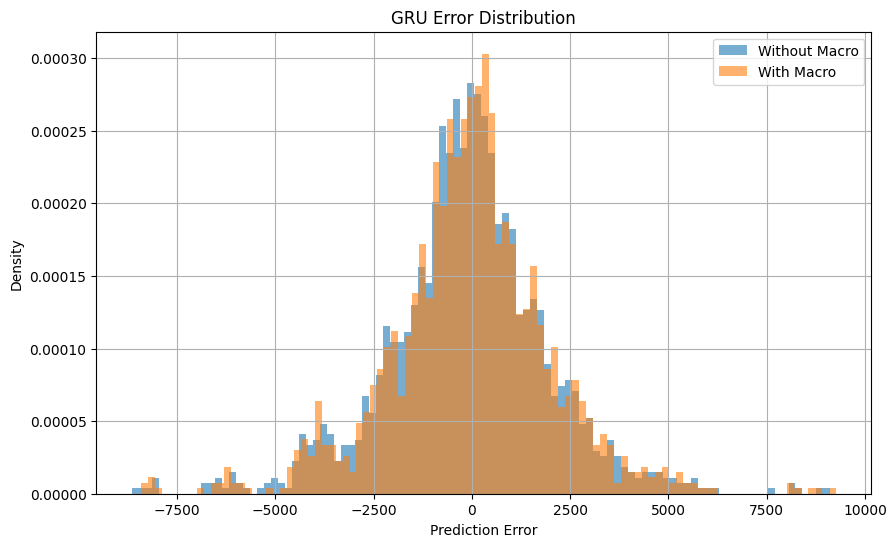

In [37]:
plt.figure(figsize=(10,6))
plt.hist(all_err_1, bins=100, alpha=0.6, density=True, label="Without Macro")
plt.hist(all_err_2, bins=100, alpha=0.6, density=True, label="With Macro")
plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.title("GRU Error Distribution")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-1004818771.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


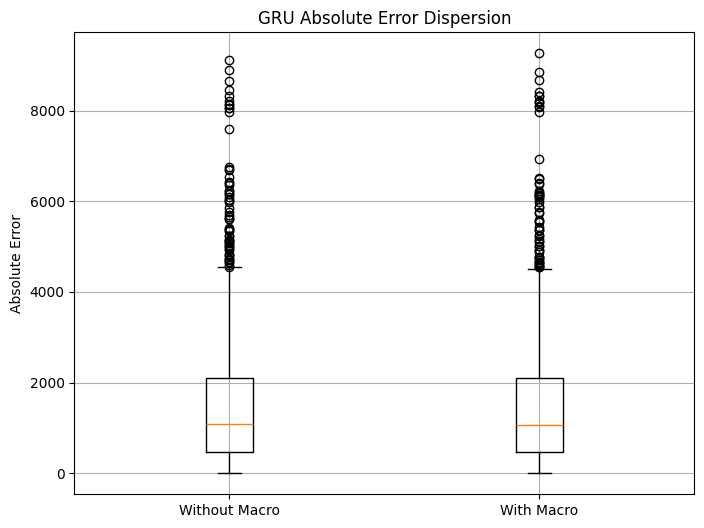

In [39]:
plt.figure(figsize=(8,6))
plt.boxplot(
    [np.abs(all_err_1), np.abs(all_err_2)],
    labels=["Without Macro", "With Macro"],
    showfliers=True
)
plt.ylabel("Absolute Error")
plt.title("GRU Absolute Error Dispersion")
plt.grid(True)
plt.show()

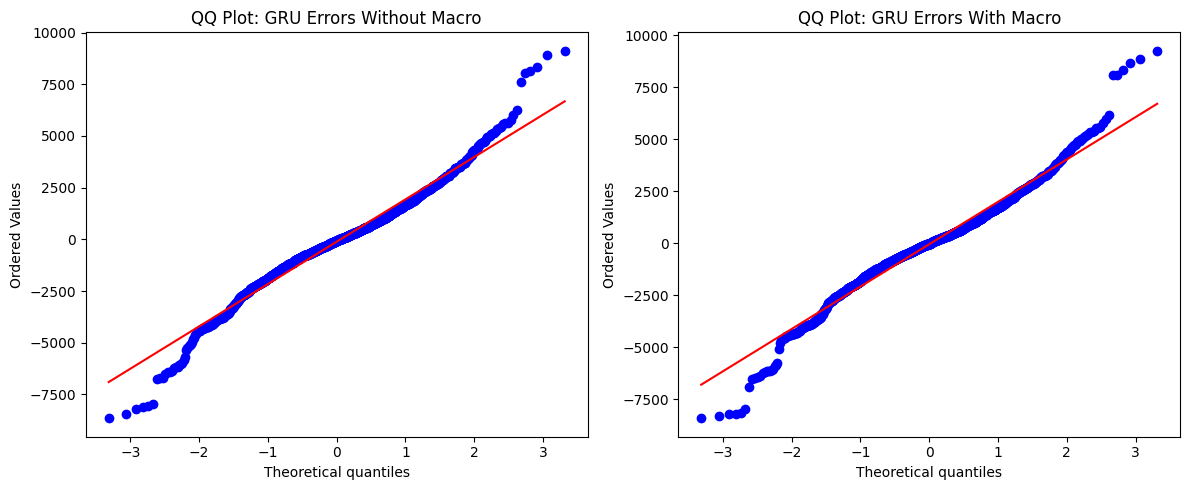

In [40]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
stats.probplot(all_err_1, dist="norm", plot=plt)
plt.title("QQ Plot: GRU Errors Without Macro")

plt.subplot(1,2,2)
stats.probplot(all_err_2, dist="norm", plot=plt)
plt.title("QQ Plot: GRU Errors With Macro")

plt.tight_layout()
plt.show()